In [1]:
## Import libraries and useful functions

library(ggplot2)
library(terra)
library(leaflet)
library(tidyr)
library(dplyr)

source("../scripts/utils.R")

terra 1.7.83


Attaching package: ‘tidyr’


The following object is masked from ‘package:terra’:

    extract



Attaching package: ‘dplyr’


The following objects are masked from ‘package:terra’:

    intersect, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
## Set paths and load data
# Input NVDI basemaps stored in country folder. 
# Area of Interest (AoI) files in AoI folder

country_name <- "Zambia"
data_type <- "NDVI"
resolution <- 1000 # in meters
data_path <- paste0("../data/", country_name, "_", resolution, "m/")
aoi_path <- "../data/AoI/"


In [3]:
## Create lists with relevant filenames. 
## Extract date, and order accordingly

# NDVI filenames
ndvi_files <- get_filenames(filepath = data_path, data_type = data_type, file_extension = ".tif", country_name = country_name)

# AoI filenames
aoi_files <- get_filenames(filepath = aoi_path, data_type = "AoI", file_extension = ".geojson", country_name = country_name)

# Extract the date part from the filenames using a regular expression
# Assumes only year and month in filename
dates <- extract_dates(file_list = ndvi_files)

# Convert extracted date strings to date objects 
# sorting files based on the date objects (ascending)
ndvi_files <- order_by_date(file_list = ndvi_files, dates = dates, decreasing = FALSE)


Loading NDVI data for Zambia 

Loading AoI data for Zambia 

Found data for 48 months, from 2020-01 to 2023-12 


In [4]:
## Load raster and vector objects

# load raster data for all months, and stack
ndvi_rast <- terra::rast(paste0(data_path, ndvi_files))

# load input Area of Interest (AoI) to later mask data
aoi_vec <- sf::st_read(paste0(aoi_path, aoi_files))

Reading layer `AoI_Mponda' from data source 
  `/data/AoI/AoI_Zambia_By_Life_Connected.geojson' using driver `GeoJSON'
Simple feature collection with 1 feature and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 26.77027 ymin: -15.1321 xmax: 26.92342 ymax: -14.85555
Geodetic CRS:  WGS 84


In [5]:
## Transform (by projecting) the raster and AoI data to useful coordinate system

# Common transformations: project a raster
# see https://epsg.io/ for projection systems
ndvi_proj <- terra::project(ndvi_rast, "EPSG:4326") 
aoi_proj <- sf::st_transform(aoi_vec, "EPSG:4326") 

In [6]:
## Mask the raster, to remove background values (if any).
ndvi_msk <- terra::mask(ndvi_proj, aoi_proj)

# change layer names for plotting
names(ndvi_msk) <- c(dates)


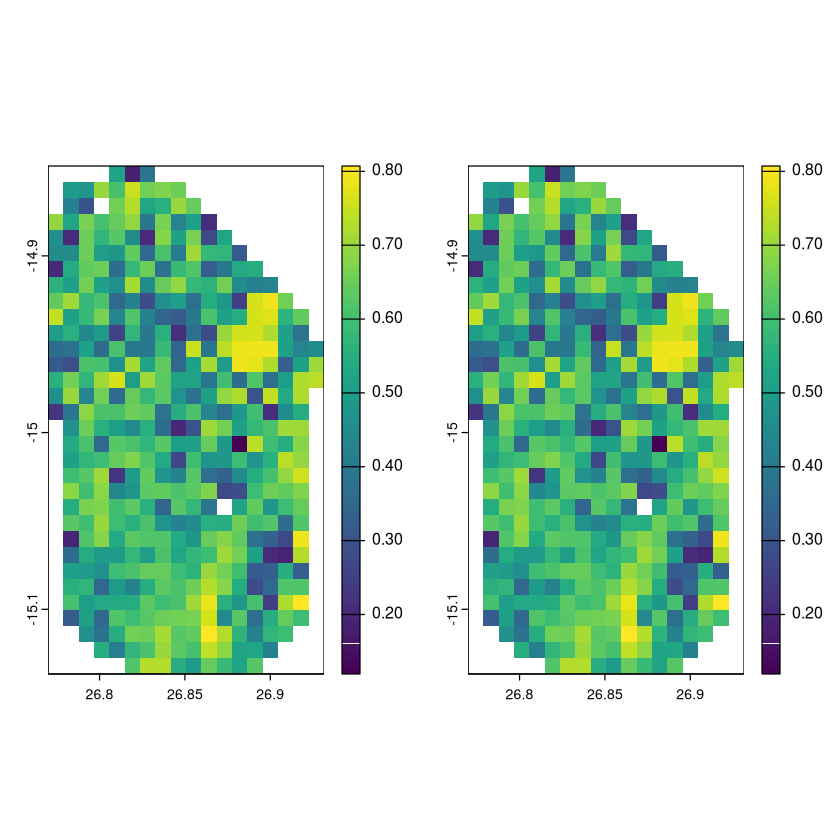

In [7]:
## Sanity check Aoi and raster data (pre and post-masking)

par(mfrow=c(1,2))
plot(ndvi_proj[[1]])
plot(ndvi_msk[[1]])

In [8]:
ndvi_msk

class       : SpatRaster 
dimensions  : 32, 18, 48  (nrow, ncol, nlyr)
resolution  : 0.008983153, 0.008983153  (x, y)
extent      : 26.7698, 26.93149, -15.13661, -14.84915  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source(s)   : memory
names       :   2020-01,    2020-02,   2020-03,   2020-04,   2020-05,   2020-06, ... 
min values  : 0.1194753, 0.09013294, 0.1178169, 0.3761970, 0.2660691, 0.1516054, ... 
max values  : 0.8071935, 0.81406158, 0.8179626, 0.7284576, 0.5952297, 0.5360231, ... 

In [9]:
## Show mean NDVI maps for each month.

# add time info for transformations
time(ndvi_msk) <- as.Date(paste0(dates, "-01"))

## get mean raster image over months
ndvi_msk_mean <- terra::tapp(ndvi_msk, "months", fun=function(x) mean(x, na.rm = TRUE))

# change layer names for plotting
month_names <- month.name[c(terra::time(ndvi_msk_mean))]
names(ndvi_msk_mean) <- c(month_names)

In [10]:
ndvi_msk_mean

class       : SpatRaster 
dimensions  : 32, 18, 12  (nrow, ncol, nlyr)
resolution  : 0.008983153, 0.008983153  (x, y)
extent      : 26.7698, 26.93149, -15.13661, -14.84915  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source(s)   : memory
names       :   January,  February,     March,     April,       May,      June, ... 
min values  : 0.2065290, 0.3530435, 0.3280724, 0.4096369, 0.3204211, 0.2334459, ... 
max values  : 0.7602214, 0.8145411, 0.7701093, 0.7441361, 0.6520932, 0.5665829, ... 
time (mnts) : Jan to Dec 

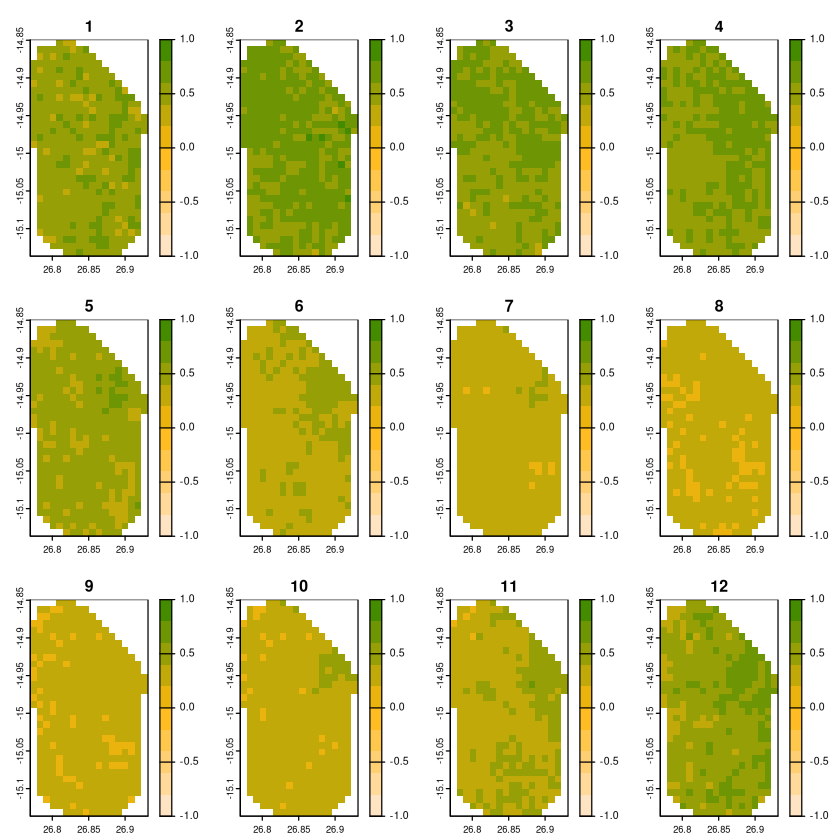

In [11]:
# plot layers

# Define a color map from brown to green
brgr.colors <- colorRampPalette(c("bisque1", "darkgoldenrod1", "chartreuse4"))

terra::plot(ndvi_msk_mean, col=brgr.colors(10), range =c(-1, 1))#, fill_range=TRUE)

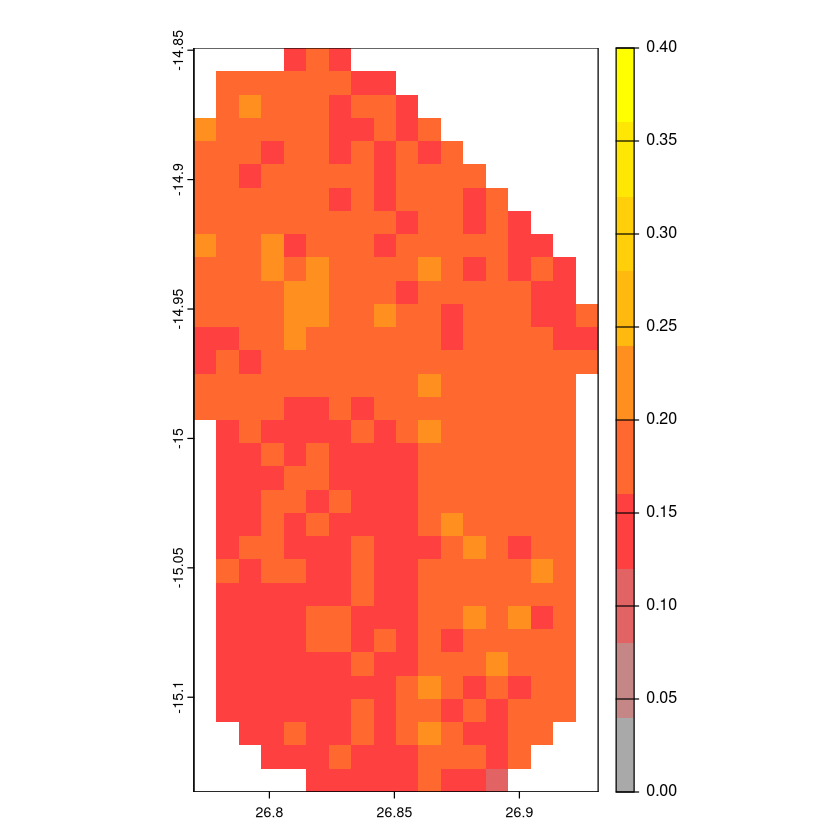

In [12]:
## Plot standard deviation raster, to see which sub-regions within map vary the most.

# Define a color map black to red to yellow 
hot.colors <- colorRampPalette(c("darkgrey", "brown1", "darkgoldenrod1", "yellow"))

terra::plot(stdev(ndvi_msk, na.rm=TRUE), col=hot.colors(10), range = c(0, .4))


In [13]:
## Inspect distribution of NDVI values throughout the year.

# Get the values in a data frame
ndvi_df <- as.data.frame(x = ndvi_msk, row.names = NULL, xy=FALSE)
colnames(ndvi_df) <- c(dates)

# Reshape data frame from wide format (one col per date) to long format (1 col for YYYY-MM id, 1 col for value)
# note that this looses spatial information since we are not tracking index of datapoint
ndvi_longdf <- ndvi_df %>%
  pivot_longer(cols = everything(), names_to = "YearMonth", values_to = "NDVI")

# drop missing values
ndvi_longdf <- na.omit(ndvi_longdf)

# split dates into month and year columns
ndvi_longdf$dates <- as.Date(paste0(ndvi_longdf$YearMonth, "-01"))
ndvi_longdf <- transform(ndvi_longdf, month = format(dates, "%m"), year = format(dates, "%Y"))


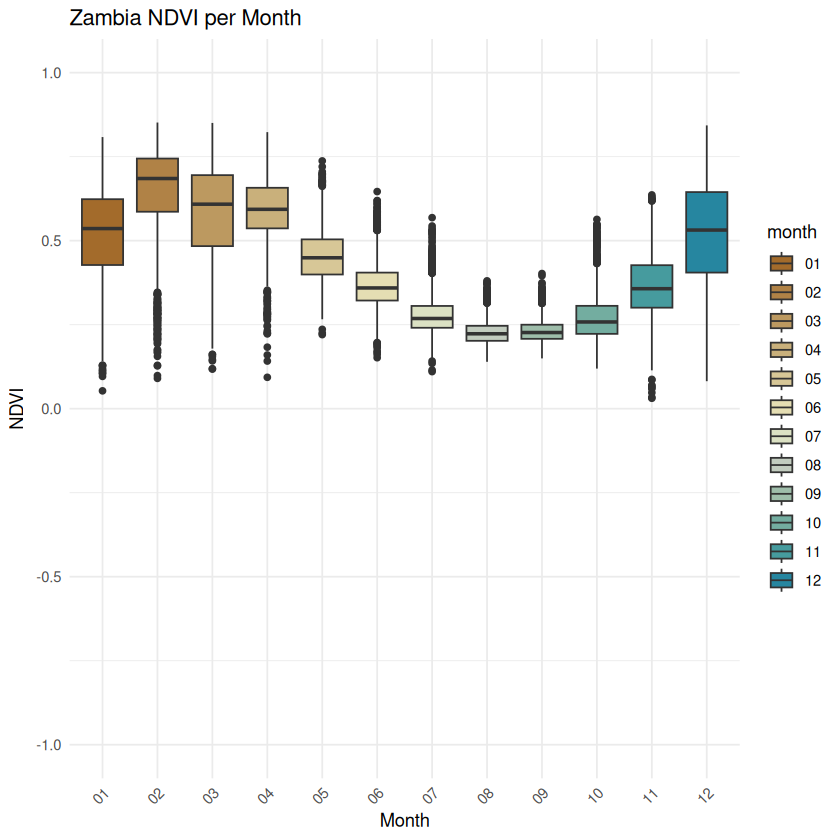

In [14]:
# Create the boxplot with ggplot2

ggplot(ndvi_longdf, aes(x = month, y = NDVI, fill=month)) +
  geom_boxplot(na.rm = TRUE) +
  theme_minimal() +
  labs(title = paste0(country_name, " NDVI per Month"), x = "Month", y = "NDVI") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))+
  ylim(-1, 1)+
  scale_fill_manual(values = hcl.colors(12, palette = "Earth"))

In [15]:
# Compute mean, SD, and confidence intervals
ndvi_summary <- ndvi_longdf %>%
  group_by(month) %>%
  summarize(
    mean_val = mean(NDVI),
    lower_ci = mean(NDVI) - 1.96 * sd(NDVI) / sqrt(length(NDVI)), # 95% CI lower bound
    upper_ci = mean(NDVI) + 1.96 * sd(NDVI) / sqrt(length(NDVI)) # 95% CI upper bound
  )

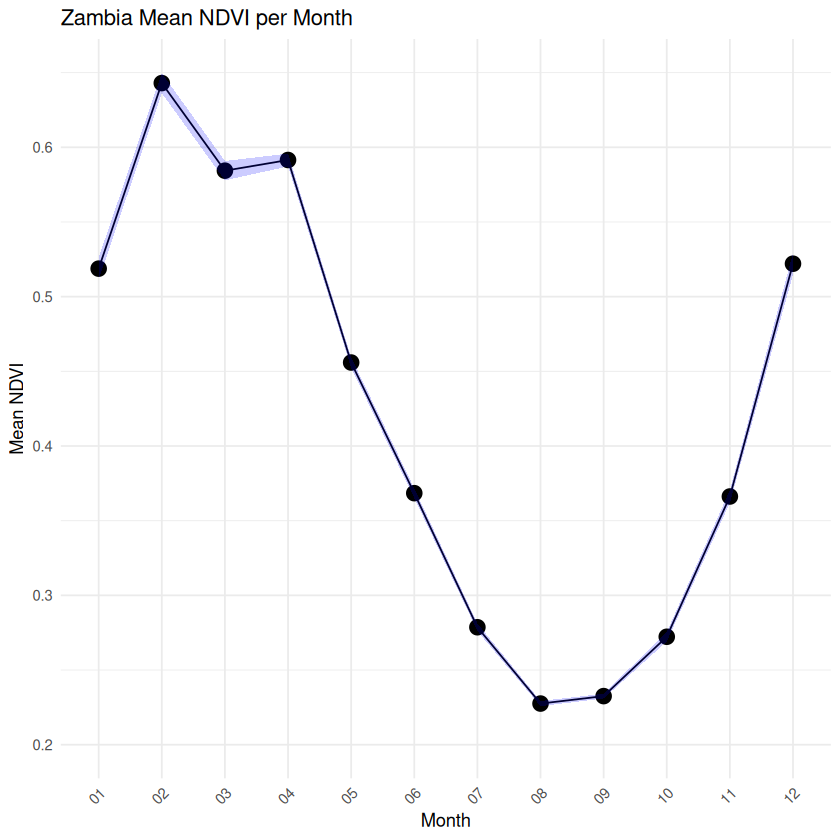

In [16]:
# Plot timeseries mean values 
# with shaded ribbon for confidence interval

ggplot(ndvi_summary, aes(x = month, y = mean_val, group = 1)) +
  geom_point(size = 4) +
  geom_line() +
  geom_ribbon(aes(ymin = lower_ci, ymax = upper_ci), alpha = 0.2, fill = "blue") + # Shaded CI ribbon
  theme_minimal() +
  labs(
    title = paste0(country_name, " Mean NDVI per Month"),
    x = "Month", 
    y = "Mean NDVI"
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(0.2, .65)